In [2]:
import numpy as np

In [3]:
park1_loop_fn = "results_avia_park/std_result_park1.csv"
park2_loop_fn = "results_avia_park/std_result_park2.csv"
park1_time_fn = "results_avia_park/std_consumption_park1.csv"
park2_time_fn = "results_avia_park/std_consumption_park2.csv"
park1_part_fn = "results_avia_park/std_avia_park1_loop_times.csv"
park2_part_fn = "results_avia_park/std_avia_park2_loop_times.csv"

In [4]:
park1_loop = np.genfromtxt(park1_loop_fn, delimiter=',')
park2_loop = np.genfromtxt(park2_loop_fn, delimiter=',')
park1_time = np.genfromtxt(park1_time_fn, delimiter=',')
park2_time = np.genfromtxt(park2_time_fn, delimiter=',')
park1_part = np.genfromtxt(park1_part_fn, delimiter=',')
park2_part = np.genfromtxt(park2_part_fn, delimiter=',')
print("park1_loop.shape: ", park1_loop.shape)
print("park2_loop.shape: ", park2_loop.shape)
print("park1_time.shape: ", park1_time.shape)
print("park2_time.shape: ", park2_time.shape)
print("park1_part.shape: ", park1_part.shape)
print("park2_part.shape: ", park2_part.shape)

def is_in_part(t_sec, part_data):
    flag = False
    eps = 0.01
    for i in range(part_data.shape[0]):
        if     t_sec >= (part_data[i,0] - eps) \
           and t_sec <= (part_data[i,1] + eps):
            flag = True
    return flag

park1_loop.shape:  (598, 8)
park2_loop.shape:  (539, 8)
park1_time.shape:  (598, 3)
park2_time.shape:  (539, 3)
park1_part.shape:  (6, 2)
park2_part.shape:  (5, 2)


### Avia Park 1 Dataset

In [5]:
SKIP_NUM = 50
SKIP_NEAR_NUM = 100
ARG_SCORE_THRES = 0.1
ARG_LOOP_THRES = 10.0

In [6]:
loop_data = park1_loop
time_data = park1_time
part_data = park1_part

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

assert(loop_data.shape[0] == time_data.shape[0])
N_DATA = loop_data.shape[0]

if N_DATA <= SKIP_NUM:
    print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
    exit(0)

for i in range(SKIP_NUM, N_DATA): #
    t_sec = loop_data[i,0]
    score = loop_data[i,1]
    t_query = loop_data[i,2:5].reshape((3,1))
    t_dbase = loop_data[i,5:8].reshape((3,1))
    
    # is_loop = False
    
    loop_candidates = loop_data[0:i-SKIP_NUM+1,2:5]
    loop_candidates_dist:np.ndarray = loop_candidates - np.tile(t_query.reshape((1,3)), (loop_candidates.shape[0],1))
    loop_candidates_dist = np.linalg.norm(loop_candidates_dist, axis=1)
    min_dist = 9999.0
    # print("loop_candidates_dist: ", loop_candidates_dist.shape)
    # print(loop_candidates_dist.tolist())
    if (loop_candidates_dist <= ARG_LOOP_THRES).any():
        # print(f"Loop exists")
        # is_loop = True
        min_dist = loop_candidates_dist.min()
    
    is_loop = is_in_part(t_sec, part_data)
    
    if score >= ARG_SCORE_THRES:
        l2_dist = ((t_query - t_dbase) ** 2)
        l2_dist = np.sqrt(np.sum(l2_dist))
        
        if is_loop or l2_dist <= ARG_LOOP_THRES:
            # print(f"[Succ] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
            true_positive += 1
        else:
            # print(f"[Fail] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
            false_positive += 1
    else:
        if is_loop:
            # print(f"Fail to detect loop, Score({score:2.4f} vs Min({min_dist:2.4f})")
            false_negative += 1
        else:
            true_negative += 1
            pass

print(f"true_positive: {true_positive}")
print(f"true_negative: {true_negative}")
print(f"false_positive: {false_positive}")
print(f"false_negative: {false_negative}")

true_positive: 45
true_negative: 391
false_positive: 23
false_negative: 89


In [7]:
SKIP_NUM = 50
ARG_LOOP_THRES = 20.0

def compute_precision_recall_etc(loop_data, part_data, score_thres):
    """ compute precision & Recall 

    Args:
        loop_data (np.ndarray): N x 8 Result data
        part_data (np.ndarray): part data which includes loop timing information
    """    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    N_DATA = loop_data.shape[0]

    if N_DATA <= SKIP_NUM:
        print(f"[WARN] dataset length({N_DATA}) is smaller than skip length({SKIP_NUM})")
        exit(0)

    for i in range(SKIP_NUM, N_DATA): #
        t_sec = loop_data[i,0]
        score = loop_data[i,1]
        t_query = loop_data[i,2:5].reshape((3,1))
        t_dbase = loop_data[i,5:8].reshape((3,1))
        
        # is_loop = False
        
        loop_candidates = loop_data[0:i-SKIP_NUM+1,2:5]
        loop_candidates_dist:np.ndarray = loop_candidates - np.tile(t_query.reshape((1,3)), (loop_candidates.shape[0],1))
        loop_candidates_dist = np.linalg.norm(loop_candidates_dist, axis=1)
        min_dist = 9999.0
        # print("loop_candidates_dist: ", loop_candidates_dist.shape)
        # print(loop_candidates_dist.tolist())
        if (loop_candidates_dist <= ARG_LOOP_THRES).any():
            # print(f"Loop exists")
            # is_loop = True
            min_dist = loop_candidates_dist.min()
        
        is_loop = is_in_part(t_sec, part_data)
        
        if score >= score_thres:
            l2_dist = ((t_query - t_dbase) ** 2)
            l2_dist = np.sqrt(np.sum(l2_dist))
            
            if is_loop or l2_dist <= ARG_LOOP_THRES:
                # print(f"[Succ] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
                true_positive += 1
            else:
                # print(f"[Fail] Idx({i:03d}): Score({score:2.4f} / Dist({l2_dist:2.4f}))")  
                false_positive += 1
        else:
            if is_loop:
                # print(f"Fail to detect loop, Score({score:2.4f} vs Min({min_dist:2.4f})")
                false_negative += 1
            else:
                true_negative += 1
                pass

    # print(f"true_positive: {true_positive}")
    # print(f"true_negative: {true_negative}")
    # print(f"false_positive: {false_positive}")
    # print(f"false_negative: {false_negative}")
    
    etc = [ true_positive, false_positive,
            true_negative, false_negative ]
    if true_positive == 0:
        return 0.0, 0.0, etc
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    return precision, recall, etc

In [ ]:

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

# - 1
part_data = np.array([[1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839519.0996,1577839523.0996],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839536.0999,1577839549.1996]])

part_data = np.array([[1577839133.0994,1577839140.0993],
                      [1577839178.0999,1577839235.1994],
                      [1577839331.1998,1577839346.0998],
                      [1577839390.0998,1577839417.1995],
                      [1577839519.0996,1577839523.0996]])

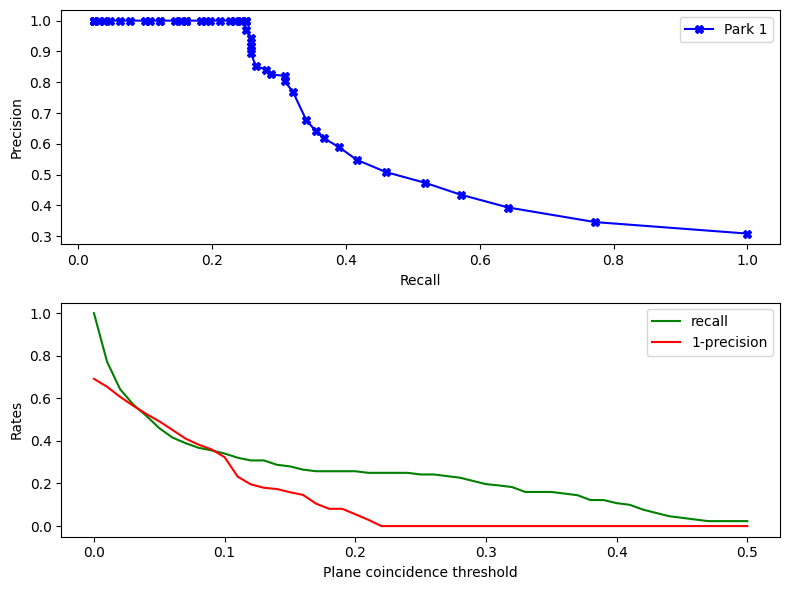

In [8]:

thres_arr = np.linspace(0.5, 0.0, 51).tolist()
# print(thres_arr)

loop_data = park1_loop
time_data = park1_time
part_data = park1_part

xs = []
precisions = []
recalls = []

for i in range(len(thres_arr)):
    precision, recall, etc = compute_precision_recall_etc(loop_data, part_data, thres_arr[i])
    xs.append(thres_arr[i])
    precisions.append(precision)
    recalls.append(recall)
    

xs = np.array(xs, dtype=float)
precisions = np.array(precisions, dtype=float)
recalls = np.array(recalls, dtype=float)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot data on the first subplot (top)
axes[0].plot(recalls, precisions, label='Park 1', color='b', marker='X')
# axes[0].set_title('Line Graph 1')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()

# Plot data on the second subplot (bottom)
axes[1].plot(xs, recalls,      label='recall', color='g')
axes[1].plot(xs, 1-precisions, label='1-precision', color='r')
# axes[1].set_title('Line Graph 2')
axes[1].set_xlabel('Plane coincidence threshold')
axes[1].set_ylabel('Rates')
axes[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


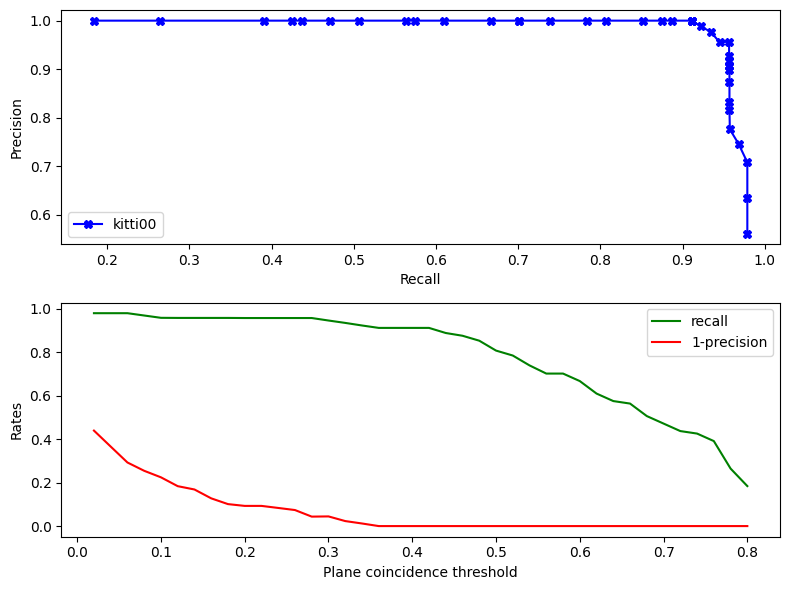

In [35]:
seq = "kitti00"
loop_fn = f"results_kitti/{seq}_std_loop.csv"
time_fn = f"results_kitti/{seq}_std_time.csv"
part_fn = f"results_kitti/{seq}_part.csv"
loop_data = np.genfromtxt(loop_fn, delimiter=',')
time_data = np.genfromtxt(time_fn, delimiter=',')
part_data = np.genfromtxt(part_fn, delimiter=',')

thres_arr = np.linspace(0.02, 0.8, 40).tolist()

xs = []
precisions = []
recalls = []

for i in range(len(thres_arr)):
    precision, recall, etc = compute_precision_recall_etc(loop_data, part_data, thres_arr[i])
    xs.append(thres_arr[i])
    precisions.append(precision)
    recalls.append(recall)
    

xs = np.array(xs, dtype=float)
precisions = np.array(precisions, dtype=float)
recalls = np.array(recalls, dtype=float)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot data on the first subplot (top)
axes[0].plot(recalls, precisions, label=seq, color='b', marker='X')
# axes[0].set_title('Line Graph 1')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()

# Plot data on the second subplot (bottom)
axes[1].plot(xs, recalls,      label='recall', color='g')
axes[1].plot(xs, 1-precisions, label='1-precision', color='r')
# axes[1].set_title('Line Graph 2')
axes[1].set_xlabel('Plane coincidence threshold')
axes[1].set_ylabel('Rates')
axes[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


(454,)


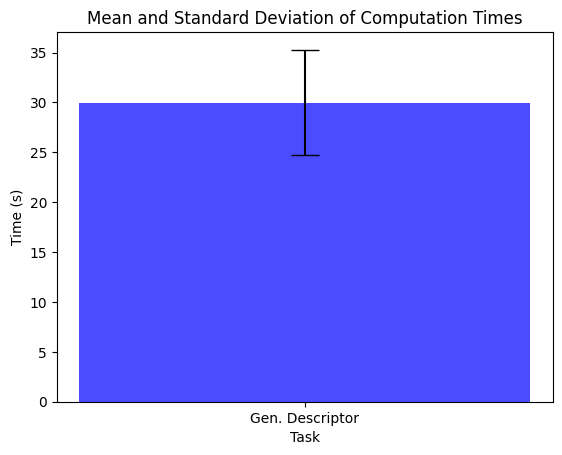

In [38]:
# Sample computation times (replace this with your data)
computation_times = [10.2, 9.5, 11.0, 10.8, 9.2, 11.5, 10.0, 9.7]

desc_times = time_data[:,0]
query_times = time_data[:,1]
update_times = time_data[:,2]
print(desc_times.shape)

desc_mean = np.mean(desc_times)
query_mean = np.mean(query_times)
update_mean = np.mean(update_times)
desc_std = np.std(desc_times)
query_std = np.std(query_times)
update_std = np.std(update_times)

# # Calculate the mean and standard deviation
# mean_time = np.mean(computation_times)
# std_dev = np.std(computation_times)

# # Data for plotting
labels = ['Gen. Descriptor']
values = [desc_mean]
error = [desc_std]

# # Create a bar graph with error bars
plt.bar(labels, values, yerr=error, color='blue', alpha=0.7, capsize=10)

# # Add labels and title
plt.xlabel('Task')
plt.ylabel('Time (s)')
plt.title('Mean and Standard Deviation of Computation Times')

# # Show the plot
plt.show()